In [2]:
import pandas as pd
import numpy as np
import torch as pt
import tqdm
from scipy.linalg import qr
import matplotlib.pyplot as plt
%matplotlib inline

pt.set_default_tensor_type('torch.FloatTensor')
#pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [3]:
from ml_lib.Controller import Controller as Control
from ml_lib.clusters.data_cluster.DataCluster import DataCluster as Data
from ml_lib.clusters.learn_cluster.LearnCluster import LearnCluster as Learn
from ml_lib.clusters.merge_cluster.MergeCluster import MergeCluster as Merge

In [4]:
from ml_lib.clusters.learn_cluster.modules.learners.SmoothLearner import SmoothLearner
from ml_lib.clusters.learn_cluster.modules.activators.LinearActivate import LinearActivate
from ml_lib.clusters.learn_cluster.modules.activators.SigmoidActivate import SigmoidActivate
from ml_lib.clusters.learn_cluster.modules.activators.TanhActivator import TanhActivator
from ml_lib.clusters.learn_cluster.modules.activators.ReluActivator import ReluActivator
from ml_lib.utils.regularizers.DualRegularizer import DualRegularizer

In [99]:
dataset = pd.read_csv('data_files/market_data.csv', index_col = 'record_date')
dataset = pd.DataFrame(
    index = pd.date_range(dataset.index.min(), dataset.index.max())
).join(
    dataset, how = 'left'
).fillna(method = 'ffill').fillna(method = 'bfill')

offset_range = 7
core_cols = dataset.columns
for offset in range(1, offset_range + 1):
    dataset = dataset.join(dataset[core_cols].shift(-offset), how = 'left', rsuffix = '|%s' % offset).dropna()

feature_cols = ['volume', 'avg_price']
target_cols = []
for offset in range(1, offset_range + 1):
    target_cols.extend([col for col in dataset.columns if col.endswith('|%s' % offset)])

In [164]:
dataset

,volume,avg_price,volume|1,avg_price|1,volume|2,avg_price|2,volume|3,avg_price|3,volume|4,avg_price|4,volume|5,avg_price|5,volume|6,avg_price|6,volume|7,avg_price|7
2016-01-01,2.197503e+09,6.10,2.154591e+09,6.07,2.713304e+09,6.13,1.475351e+09,6.04,1.385807e+09,6.04,2.229306e+09,6.06,2.465138e+09,6.08,1.592646e+09,6.04
2016-01-02,2.154591e+09,6.07,2.713304e+09,6.13,1.475351e+09,6.04,1.385807e+09,6.04,2.229306e+09,6.06,2.465138e+09,6.08,1.592646e+09,6.04,2.840801e+09,6.04
2016-01-03,2.713304e+09,6.13,1.475351e+09,6.04,1.385807e+09,6.04,2.229306e+09,6.06,2.465138e+09,6.08,1.592646e+09,6.04,2.840801e+09,6.04,3.071255e+09,6.10
2016-01-04,1.475351e+09,6.04,1.385807e+09,6.04,2.229306e+09,6.06,2.465138e+09,6.08,1.592646e+09,6.04,2.840801e+09,6.04,3.071255e+09,6.10,2.297309e+09,6.12
2016-01-05,1.385807e+09,6.04,2.229306e+09,6.06,2.465138e+09,6.08,1.592646e+09,6.04,2.840801e+09,6.04,3.071255e+09,6.10,2.297309e+09,6.12,2.025665e+09,6.05
2016-01-06,2.229306e+09,6.06,2.465138e+09,6.08,1.592646e+09,6.04,2.840801e+09,6.04,3.071255e+09,6.10,2.297309e+09,6.12,2.025665e+09,6.05,1.736558e+09,6.09
2016-01-07,2.465138e+09,6.08,1.592646e+09,6.04,2.840801e+09,6.04,3.071255e+09,6.10,2.297309e+09,6.12,2.025665e+09,6.05,1.736558e+09,6.09,1.543560e+09,6.03
2016-01-08,1.592646e+09,6.04,2.840801e+09,6.04,3.071255e+09,6.10,2.297309e+09,6.12,2.025665e+09,6.05,1.736558e+09,6.09,1.543560e+09,6.03,2.725366e+09,6.08
2016-01-09,2.840801e+09,6.04,3.071255e+09,6.10,2.297309e+09,6.12,2.025665e+09,6.05,1.736558e+09,6.09,1.543560e+09,6.03,2.725366e+09,6.08,2.558932e+09,6.11
2016-01-10,3.071255e+09,6.10,2.297309e+09,6.12,2.025665e+09,6.05,1.736558e+09,6.09,1.543560e+09,6.03,2.725366e+09,6.08,2.558932e+09,6.11,3.036295e+09,6.15


In [186]:
feature_tensor = pt.from_numpy(dataset[feature_cols].values).type(pt.Tensor)
target_tensor = pt.from_numpy(dataset[target_cols].values).type(pt.Tensor)

In [187]:
seeds = pt.zeros(2, len(feature_cols))
coefs = pt.zeros(2, len(feature_cols))

In [188]:
learn_rate = 1e-1

alpha = 0.2
beta = 0.1
clamp = 1e-16

grad_coefs = 0
grad_sq_coefs = 0

grad_seeds = 0
grad_sq_seeds = 0

loss_rcd = []

In [189]:
t = tqdm.tnrange(250)
for i in t:
    seeds.requires_grad = True
    coefs.requires_grad = True

    coefs_sig = 1 / (1 + pt.exp(-coefs))

    smooth_level = [seeds[0,:]]
    smooth_trend = [seeds[1,:]]
    
    for row in feature_tensor:
        new_level = (
            (1 - coefs_sig[0,:]) * row
        ) + (
            coefs_sig[0,:] * (smooth_level[-1] + smooth_trend[-1])
        )
        new_trend = (
            (1 - coefs_sig[1,:]) * (new_level - smooth_level[-1])
        ) + (
            coefs_sig[1,:] * smooth_trend[-1]
        )

        smooth_level.append(new_level)
        smooth_trend.append(new_trend)
    
    smooth_level = pt.stack(smooth_level[1:])
    smooth_trend = pt.stack(smooth_trend[1:])

    predict_tensor = []
    for offset in range(1, offset_range + 1):
        predict_slice = smooth_level + (smooth_trend * offset)
        predict_tensor.append(predict_slice)
    predict_tensor = pt.cat(predict_tensor, dim = 1)

    loss = pt.sqrt((((target_tensor - predict_tensor) / target_tensor) ** 2).mean(dim = 0)).sum()
    loss_rcd.append(loss.detach().cpu().numpy())
    t.set_postfix({'loss': loss_rcd[-1]})

    coefs_grad, seeds_grad = pt.autograd.grad(loss, [coefs, seeds])
    
    with pt.no_grad():
        grad_coefs = (alpha * coefs_grad) + ((1 - alpha) * grad_coefs)
        grad_sq_coefs = (beta * (coefs_grad ** 2)) + ((1 - beta) * grad_sq_coefs)
        
        grad_seeds = (alpha * seeds_grad) + ((1 - alpha) * grad_seeds)
        grad_sq_seeds = (beta * (seeds_grad ** 2)) + ((1 - beta) * grad_sq_seeds)
        
        coefs_step = grad_coefs / pt.clamp(pt.sqrt(grad_sq_coefs), clamp, np.inf)
        seeds_step = grad_seed / pt.clamp(pt.sqrt(grad_sq_seed), clamp, np.inf)
        
        coefs = coefs - (coefs_step * learn_rate / 8)
        seeds = seeds - (seeds_step * learn_rate / 8)

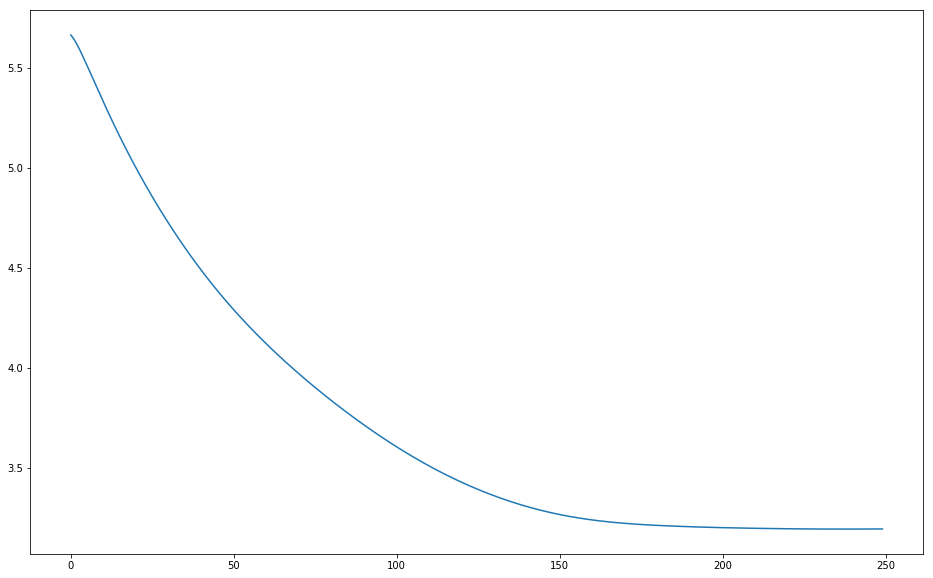

In [190]:
plt.figure(figsize=(16, 10))
plt.plot(loss_rcd)

In [191]:
pd.DataFrame(1 / (1 + np.exp(-coefs.detach().cpu().numpy())))

,0,1
0,0.874186,0.251510
1,0.949568,0.894725


In [192]:
pd.DataFrame(seed_tensor.detach().cpu().numpy())

,0,1
0,58.703186,6.064023
1,-57.420940,0.011284
